# EDA #

History:

hour — в какой час пользователь видел объявление;

cpm — цена показанного рекламного объявления в рекламном аукционе. Это значит, что на данном аукционе это была максимальная ставка;

publisher — площадка, на который пользователь увидел рекламу;

user_id — уникальный идентификатор пользователя.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import optuna.visualization as vis

# Настройка стиля
#plt.style.use('seaborn')
sns.set_palette("husl")

# Загружаем данные
df_history = pd.read_csv('history.tsv', sep='\t')

# Исследуем структуру данных
print("Информация о датасете:")
df_history.info()

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147857 entries, 0 to 1147856
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   hour       1147857 non-null  int64  
 1   cpm        1147857 non-null  float64
 2   publisher  1147857 non-null  int64  
 3   user_id    1147857 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 35.0 MB


In [2]:
df_history.head()

,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148


In [3]:
#добавим признак преобразованные из часов в часы в сутках
df_history['hour_normalized'] = df_history['hour'] % 24

Users:

user_id — уникальный идентификатор пользователя;

sex — указанный пользователем пол в анкете;

age — указанный пользователем в анкете возраст пользователя. 0 — не указан;

city_id — указанный пользователем в анкете город проживания. 0 — не указан.

In [4]:
# Загружаем данные
df_users = pd.read_csv('users.tsv', sep='\t')

# Исследуем структуру данных
print("Информация о датасете:")
df_users.info()

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27769 entries, 0 to 27768
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  27769 non-null  int64
 1   sex      27769 non-null  int64
 2   age      27769 non-null  int64
 3   city_id  27769 non-null  int64
dtypes: int64(4)
memory usage: 867.9 KB


In [5]:
df_users.head()

,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4


In [6]:
# Заменяем возраст на 0 для всех, у кого возраст больше 80
df_users.loc[df_users['age'] > 80, 'age'] = 0

In [7]:
# Объединяем датафреймы по столбцу user_id
df_combined = df_history.merge(df_users, on='user_id', how='left')

# Проверяем результат
print("Информация об объединенном датасете:")
df_combined.info()


Информация об объединенном датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147857 entries, 0 to 1147856
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   hour             1147857 non-null  int64  
 1   cpm              1147857 non-null  float64
 2   publisher        1147857 non-null  int64  
 3   user_id          1147857 non-null  int64  
 4   hour_normalized  1147857 non-null  int64  
 5   sex              1147857 non-null  int64  
 6   age              1147857 non-null  int64  
 7   city_id          1147857 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 70.1 MB


In [8]:
df_combined.head()

,hour,cpm,publisher,user_id,hour_normalized,sex,age,city_id
0,10,30.00,1,15661,10,2,28,68
1,8,41.26,1,8444,8,1,41,0
2,7,360.00,1,15821,7,1,24,0
3,18,370.00,1,21530,18,2,17,13
4,8,195.00,2,22148,8,1,23,7


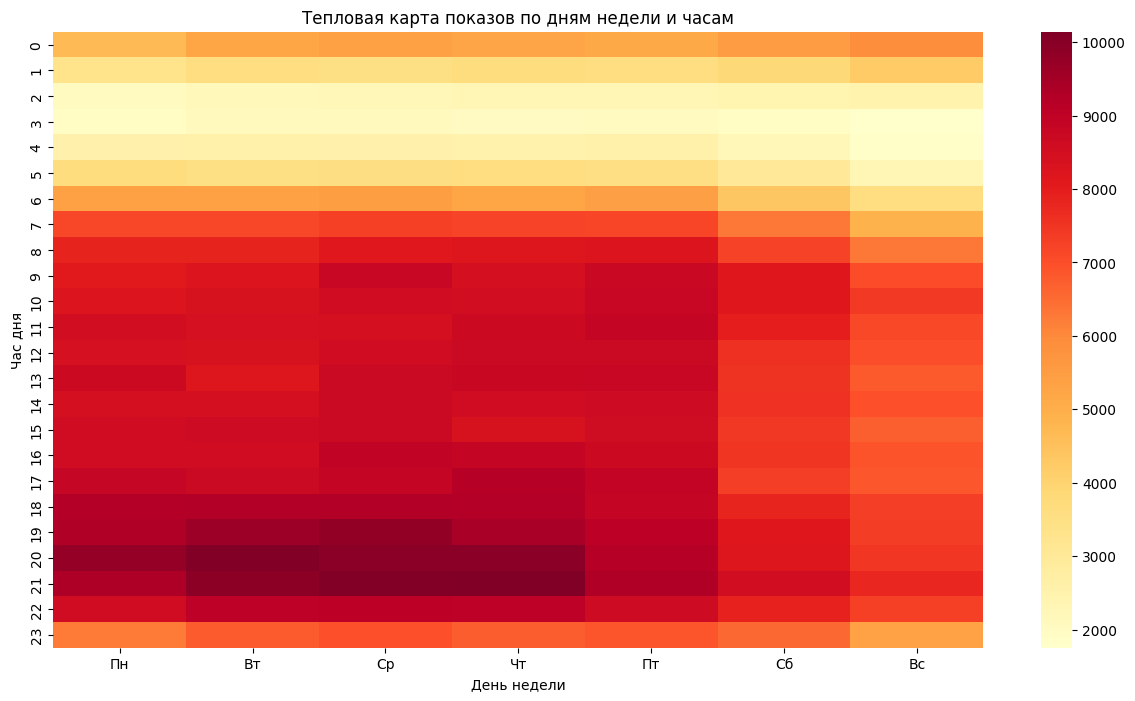

In [9]:
# Добавляем столбец с днями недели (считая от понедельника)
df_combined['weekday'] = df_combined['hour'] // 24  # целочисленное деление на 24 даст нам день недели
df_combined['weekday'] = df_combined['weekday'] % 7  # убеждаемся, что не выходим за пределы недели

# Можно также сделать тепловую карту по дням недели и часам
plt.figure(figsize=(15, 8))
df_combined['hour_of_day'] = df_combined['hour_normalized']
pivot_table = df_combined.pivot_table(
    values='user_id', 
    index='hour_of_day',
    columns='weekday', 
    aggfunc='count'
)
sns.heatmap(pivot_table, 
            cmap='YlOrRd',
            xticklabels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'],
            yticklabels=range(24))
plt.title('Тепловая карта показов по дням недели и часам')
plt.xlabel('День недели')
plt.ylabel('Час дня')
plt.show()

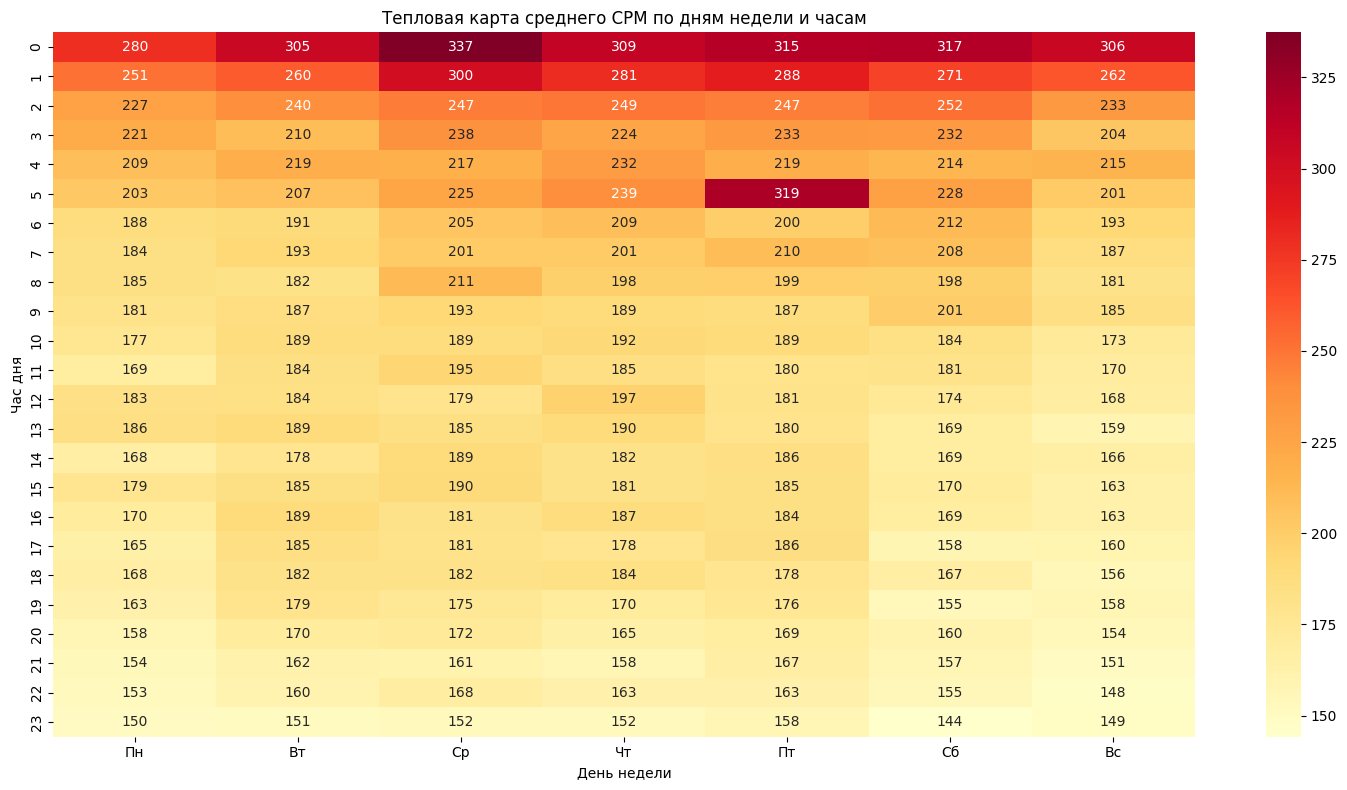

In [10]:
# Создаем тепловую карту
plt.figure(figsize=(15, 8))

# Создаем сводную таблицу со средним CPM
pivot_table = df_combined.pivot_table(
    values='cpm',
    index='hour_normalized',
    columns='weekday',
    aggfunc='mean'
)

# Создаем тепловую карту и сохраняем объект
heatmap = sns.heatmap(
    pivot_table,
    cmap='YlOrRd',  # цветовая схема от желтого к красному
    annot=True,     # показываем значения
    fmt='.0f',      # округляем значения до целых чисел
    xticklabels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'],
    yticklabels=range(24)
)

plt.title('Тепловая карта среднего CPM по дням недели и часам')
plt.xlabel('День недели')
plt.ylabel('Час дня')

# Теперь colorbar добавится автоматически
plt.tight_layout()
plt.show()

C:\Users\Yakov\AppData\Local\Temp\ipykernel_11528\1404727968.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cpm_stats = df_combined.groupby('age_group')['cpm'].agg(['mean', 'count']).round(2)


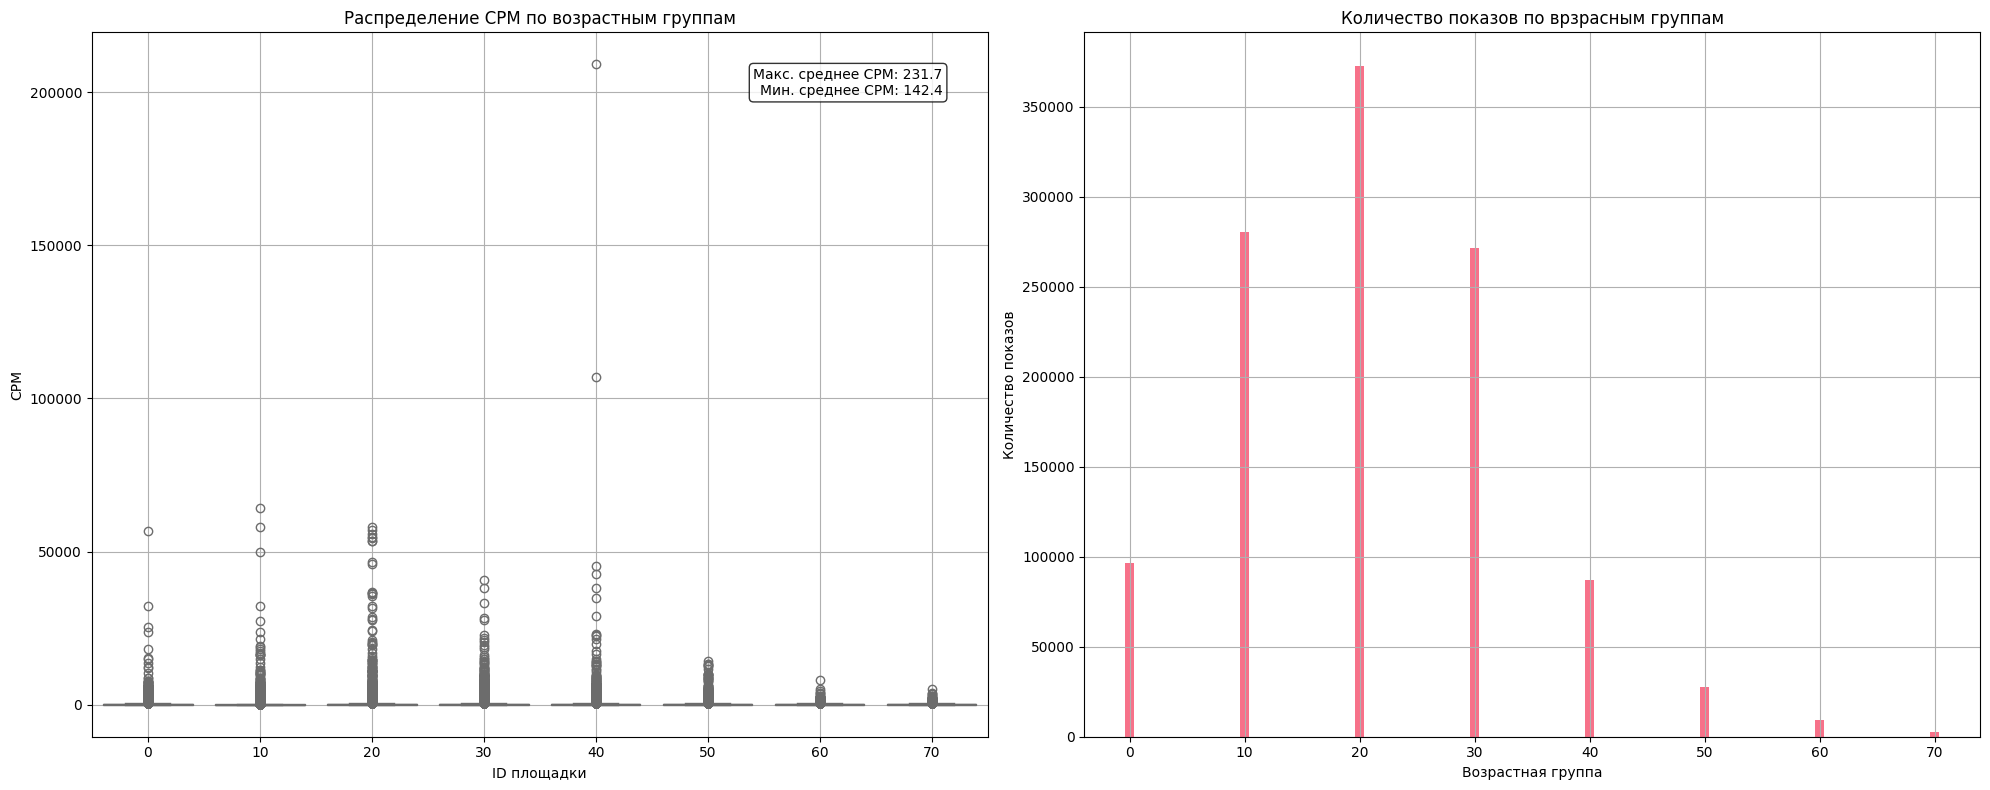

In [11]:
# Создаем возрастные группы по 10 лет
df_combined['age_group'] = pd.cut(df_combined['age'], 
                                bins=[0, 10, 20, 30, 40, 50, 60, 70, 80], 
                                labels=[0, 10, 20, 30, 40, 50, 60, 70],
                                include_lowest=True)

# Создаем подграфики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# График 1: Среднее CPM по площадкам
sns.boxplot(
    data=df_combined,
    x='age_group',
    y='cpm',
    ax=ax1
)
ax1.set_title('Распределение CPM по возрастным группам')
ax1.set_xlabel('ID площадки')
ax1.set_ylabel('CPM')
ax1.grid(True)

# Добавляем статистику по CPM
cpm_stats = df_combined.groupby('age_group')['cpm'].agg(['mean', 'count']).round(2)
stats_text = f'Макс. среднее CPM: {cpm_stats["mean"].max():.1f}\n'
stats_text += f'Мин. среднее CPM: {cpm_stats["mean"].min():.1f}'
ax1.text(0.95, 0.95, stats_text,
         transform=ax1.transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# График 2: Количество показов по площадкам
age_group_counts = df_combined['age_group'].value_counts().sort_index()
ax2.bar(age_group_counts.index, age_group_counts.values)
ax2.set_title('Количество показов по врзрасным группам')
ax2.set_xlabel('Возрастная группа')
ax2.set_ylabel('Количество показов')
ax2.grid(True)


plt.tight_layout()
plt.show()


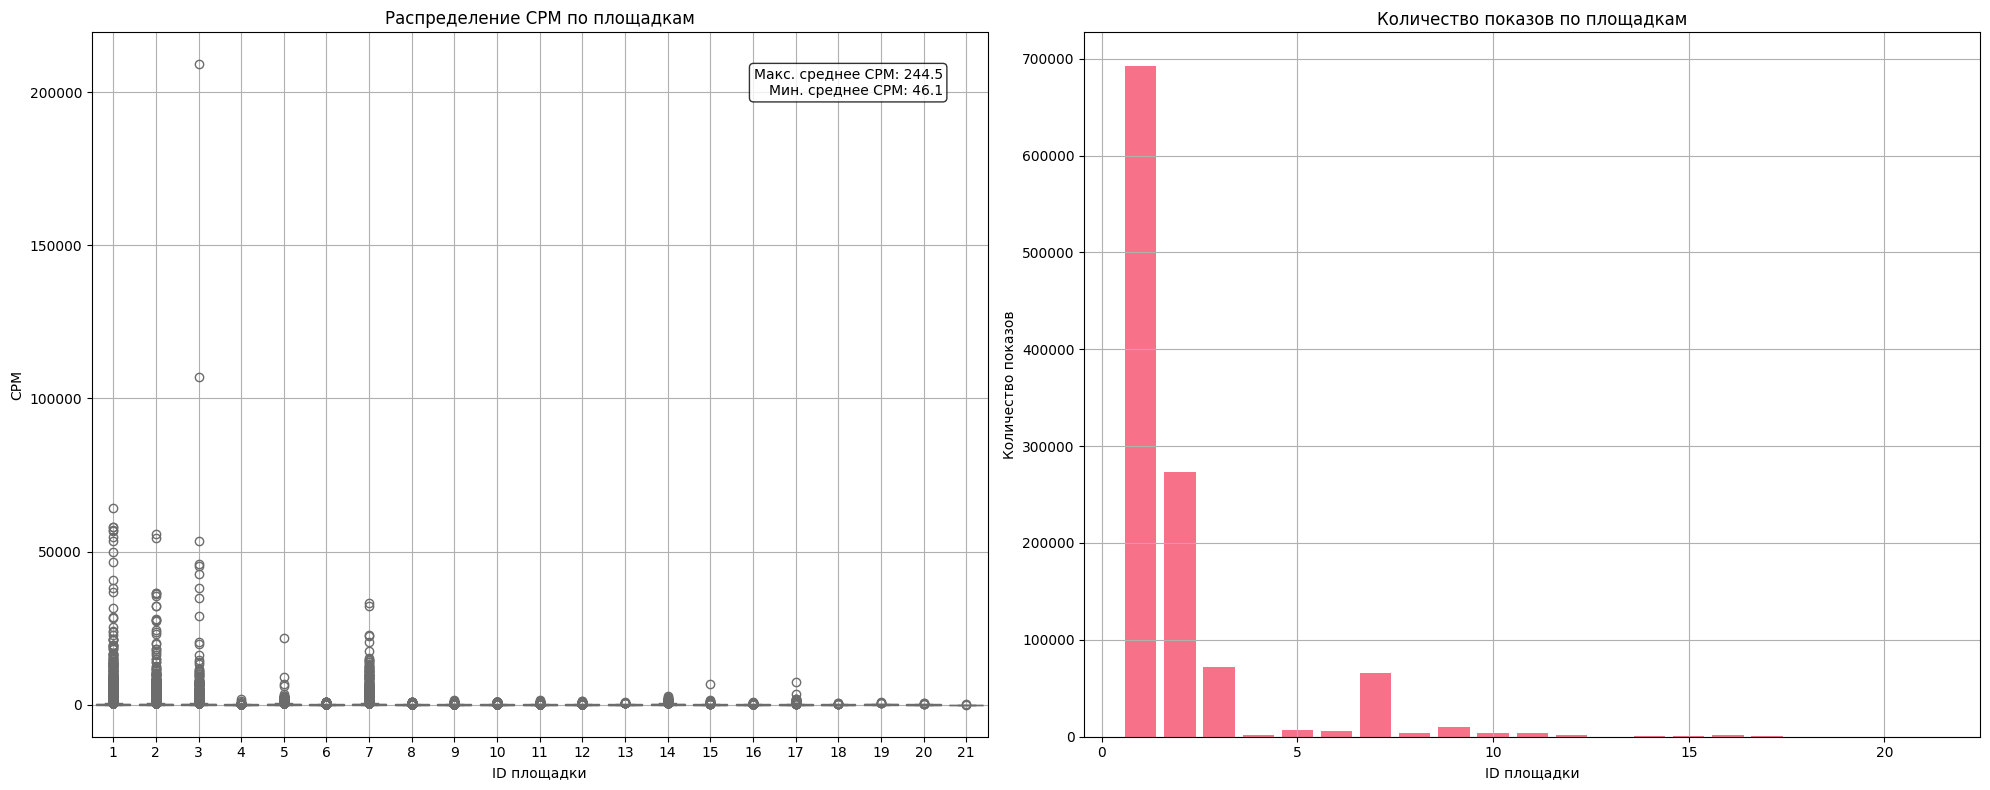

In [12]:
# Создаем подграфики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# График 1: Среднее CPM по площадкам
sns.boxplot(
    data=df_combined,
    x='publisher',
    y='cpm',
    ax=ax1
)
ax1.set_title('Распределение CPM по площадкам')
ax1.set_xlabel('ID площадки')
ax1.set_ylabel('CPM')
ax1.grid(True)

# Добавляем статистику по CPM
cpm_stats = df_combined.groupby('publisher')['cpm'].agg(['mean', 'count']).round(2)
stats_text = f'Макс. среднее CPM: {cpm_stats["mean"].max():.1f}\n'
stats_text += f'Мин. среднее CPM: {cpm_stats["mean"].min():.1f}'
ax1.text(0.95, 0.95, stats_text,
         transform=ax1.transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# График 2: Количество показов по площадкам
publisher_counts = df_combined['publisher'].value_counts().sort_index()
ax2.bar(publisher_counts.index, publisher_counts.values)
ax2.set_title('Количество показов по площадкам')
ax2.set_xlabel('ID площадки')
ax2.set_ylabel('Количество показов')
ax2.grid(True)



plt.tight_layout()
plt.show()



In [13]:
df_combined.head()

,hour,cpm,publisher,user_id,hour_normalized,sex,age,city_id,weekday,hour_of_day,age_group
0,10,30.00,1,15661,10,2,28,68,0,10,20
1,8,41.26,1,8444,8,1,41,0,0,8,40
2,7,360.00,1,15821,7,1,24,0,0,7,20
3,18,370.00,1,21530,18,2,17,13,0,18,10
4,8,195.00,2,22148,8,1,23,7,0,8,20


In [14]:
df_validate = pd.read_csv('validate.tsv', sep='\t')

# Исследуем структуру данных
print("Информация о датасете:")
df_validate.info()

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cpm            1008 non-null   float64
 1   hour_start     1008 non-null   int64  
 2   hour_end       1008 non-null   int64  
 3   publishers     1008 non-null   object 
 4   audience_size  1008 non-null   int64  
 5   user_ids       1008 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 47.4+ KB


In [15]:
df_validate.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1..."
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3..."
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5..."
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524..."
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2..."


In [16]:
df_validate_answers = pd.read_csv('validate_answers.tsv', sep='\t')

# Исследуем структуру данных
print("Информация о датасете:")
df_validate_answers.info()

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   at_least_one    1008 non-null   float64
 1   at_least_two    1008 non-null   float64
 2   at_least_three  1008 non-null   float64
dtypes: float64(3)
memory usage: 23.8 KB


In [17]:
df_validate_answers.head()

,at_least_one,at_least_two,at_least_three
0,0.0430,0.0152,0.0073
1,0.0130,0.0000,0.0000
2,0.0878,0.0135,0.0000
3,0.2295,0.1295,0.0727
4,0.3963,0.2785,0.2270


# Модель #

## Подготовка данных ##

In [18]:
def get_user_session_stats(df_combined, user_id):
    """Получает статистику сессий пользователя"""
    user_data = df_combined[df_combined['user_id'] == user_id].sort_values('hour')
    
    # Находим разрывы между показами
    time_gaps = user_data['hour'].diff()
    
    # Сессия заканчивается, если разрыв больше 6 часов
    new_sessions = time_gaps > 6
    
    return {
        'total_impressions': len(user_data),
        'num_sessions': new_sessions.sum() + 1,
        'avg_session_length': len(user_data) / (new_sessions.sum() + 1)
    }

def estimate_view_probability(row, df_combined):
    """Оценивает вероятность просмотра с учетом демографии"""
    parsed = {
        'cpm': row['cpm'],
        'hour_start': row['hour_start'],
        'hour_end': row['hour_end'],
        'publishers': set(map(int, str(row['publishers']).split(','))),
        'audience_size': row['audience_size']
    }
    
    # Фильтруем исторические данные по часам в сутках
    start_hour = parsed['hour_start'] % 24
    end_hour = parsed['hour_end'] % 24
    
    if end_hour < start_hour:  # если период переходит через полночь
        relevant_history = df_combined[
            (df_combined['hour_normalized'] >= start_hour) | 
            (df_combined['hour_normalized'] <= end_hour)
        ]
    else:
        relevant_history = df_combined[
            df_combined['hour_normalized'].between(start_hour, end_hour)
        ]
    
    # Если данных все еще нет, берем все данные
    if len(relevant_history) == 0:
        relevant_history = df_combined
    
    # Базовые метрики по CPM
    higher_bids = (relevant_history['cpm'] > parsed['cpm']).mean()
    equal_bids = (relevant_history['cpm'] == parsed['cpm']).mean()
    
    # Анализ по издателям
    publisher_data = relevant_history[
        relevant_history['publisher'].isin(parsed['publishers'])
    ]
    
    features = {
        # Существующие базовые признаки
        'time_window': parsed['hour_end'] - parsed['hour_start'],
        'cpm': parsed['cpm'],
        
        # Признаки аукциона
        'higher_bid_ratio': higher_bids if not np.isnan(higher_bids) else 0,
        'equal_bid_ratio': equal_bids if not np.isnan(equal_bids) else 0,
        
        # Признаки издателей
        'num_publishers': len(parsed['publishers']),
        'audience_size': parsed['audience_size'],
        'avg_publisher_cpm': publisher_data['cpm'].mean() if len(publisher_data) > 0 else 0,
        'publisher_impressions': len(publisher_data),
        
        # Демографические признаки
        'avg_age': relevant_history['age'].mean() if len(relevant_history) > 0 else 0,
       # 'female_ratio': (relevant_history['sex'] == 2).mean() if len(relevant_history) > 0 else 0,
        
        # Возрастные группы
        'age_19_25': ((relevant_history['age'] >= 19) & (relevant_history['age'] <= 25)).mean() if len(relevant_history) > 0 else 0,
        'age_26_35': ((relevant_history['age'] >= 26) & (relevant_history['age'] <= 35)).mean() if len(relevant_history) > 0 else 0,
        'age_36_45': ((relevant_history['age'] >= 36) & (relevant_history['age'] <= 45)).mean() if len(relevant_history) > 0 else 0,
        'age_45_60': ((relevant_history['age'] >= 45) & (relevant_history['age'] <= 60)).mean() if len(relevant_history) > 0 else 0,
        
        # Географические признаки
        'unique_cities': relevant_history['city_id'].nunique() if len(relevant_history) > 0 else 0,
        
        # Новые признаки взаимодействия
        'cpm_by_day': parsed['cpm'] * (row['hour_start'] // 24 % 7),
        
        # Новые агрегации по издателям
        'publisher_city_diversity': relevant_history.groupby('publisher')['city_id'].nunique().mean() if len(relevant_history) > 0 else 0,
        
        # Новые пользовательские метрики
        'user_impression_count': relevant_history.groupby('user_id').size().mean() if len(relevant_history) > 0 else 0,
        'user_publisher_diversity': relevant_history.groupby('user_id')['publisher'].nunique().mean() if len(relevant_history) > 0 else 0,
        
        # Новые комплексные метрики
        'relative_publisher_cpm': parsed['cpm'] / relevant_history.groupby('publisher')['cpm'].mean().mean() if len(relevant_history) > 0 else 1,
        'relative_city_cpm': parsed['cpm'] / relevant_history.groupby('city_id')['cpm'].mean().mean() if len(relevant_history) > 0 else 1,
        
      }
    
    return features

def prepare_training_data(df_validate, df_combined):
    """Подготовка данных для обучения"""
    features = []
    for _, row in df_validate.iterrows():
        row_features = estimate_view_probability(row, df_combined)
        features.append(row_features)
    
    return pd.DataFrame(features)



In [19]:
# Проверяем
first_row = df_validate.iloc[0]

# Извлекаем признаки для первой строки
features = estimate_view_probability(first_row, df_combined)

features

{'time_window': 95,
 'cpm': 220.0,
 'higher_bid_ratio': 0.23634738473520656,
 'equal_bid_ratio': 0.000520099629134988,
 'num_publishers': 2,
 'audience_size': 1906,
 'avg_publisher_cpm': 243.3442303172738,
 'publisher_impressions': 67229,
 'avg_age': 26.123057140392923,
 'age_19_25': 0.24407657051357443,
 'age_26_35': 0.3116895223011229,
 'age_36_45': 0.13768526915809198,
 'age_45_60': 0.059104052159807366,
 'unique_cities': 2328,
 'cpm_by_day': 440.0,
 'publisher_city_diversity': 320.85714285714283,
 'user_impression_count': 44.95054041353384,
 'user_publisher_diversity': 1.475172305764411,
 'relative_publisher_cpm': 1.5816220900264633,
 'relative_city_cpm': 1.1607913343111333}

In [20]:
# Разделение выборки

from sklearn.model_selection import train_test_split

# Подготовка данных
X = prepare_training_data(df_validate, df_combined)
y = df_validate_answers

# Разделение на обучающую и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Разделение временной выборки на тестовую и валидационную
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

## Функция ошибки ##

In [21]:
def get_smoothed_log_mape_column_value(responses_column, answers_column, epsilon):
    return np.abs(np.log(
        (responses_column + epsilon)
        / (answers_column + epsilon)
    )).mean()


def get_smoothed_mean_log_accuracy_ratio(answers, responses, epsilon=0.005):
    log_accuracy_ratio_mean = np.array(
        [
            get_smoothed_log_mape_column_value(responses.at_least_one, answers.at_least_one, epsilon),
            get_smoothed_log_mape_column_value(responses.at_least_two, answers.at_least_two, epsilon),
            get_smoothed_log_mape_column_value(responses.at_least_three, answers.at_least_three, epsilon),
        ]
    ).mean()

    percentage_error = 100 * (np.exp(log_accuracy_ratio_mean) - 1)

    return percentage_error.round(
        decimals=2
    )


def getsingleerror(answers, responses, epsilon=0.005):
    log_accuracy_ratio_mean = get_smoothed_log_mape_column_value(answers, responses, epsilon)

    percentage_error = 100 * (np.exp(log_accuracy_ratio_mean) - 1)

    return percentage_error

## Обучение и optuna ##

In [22]:
best_models = {}

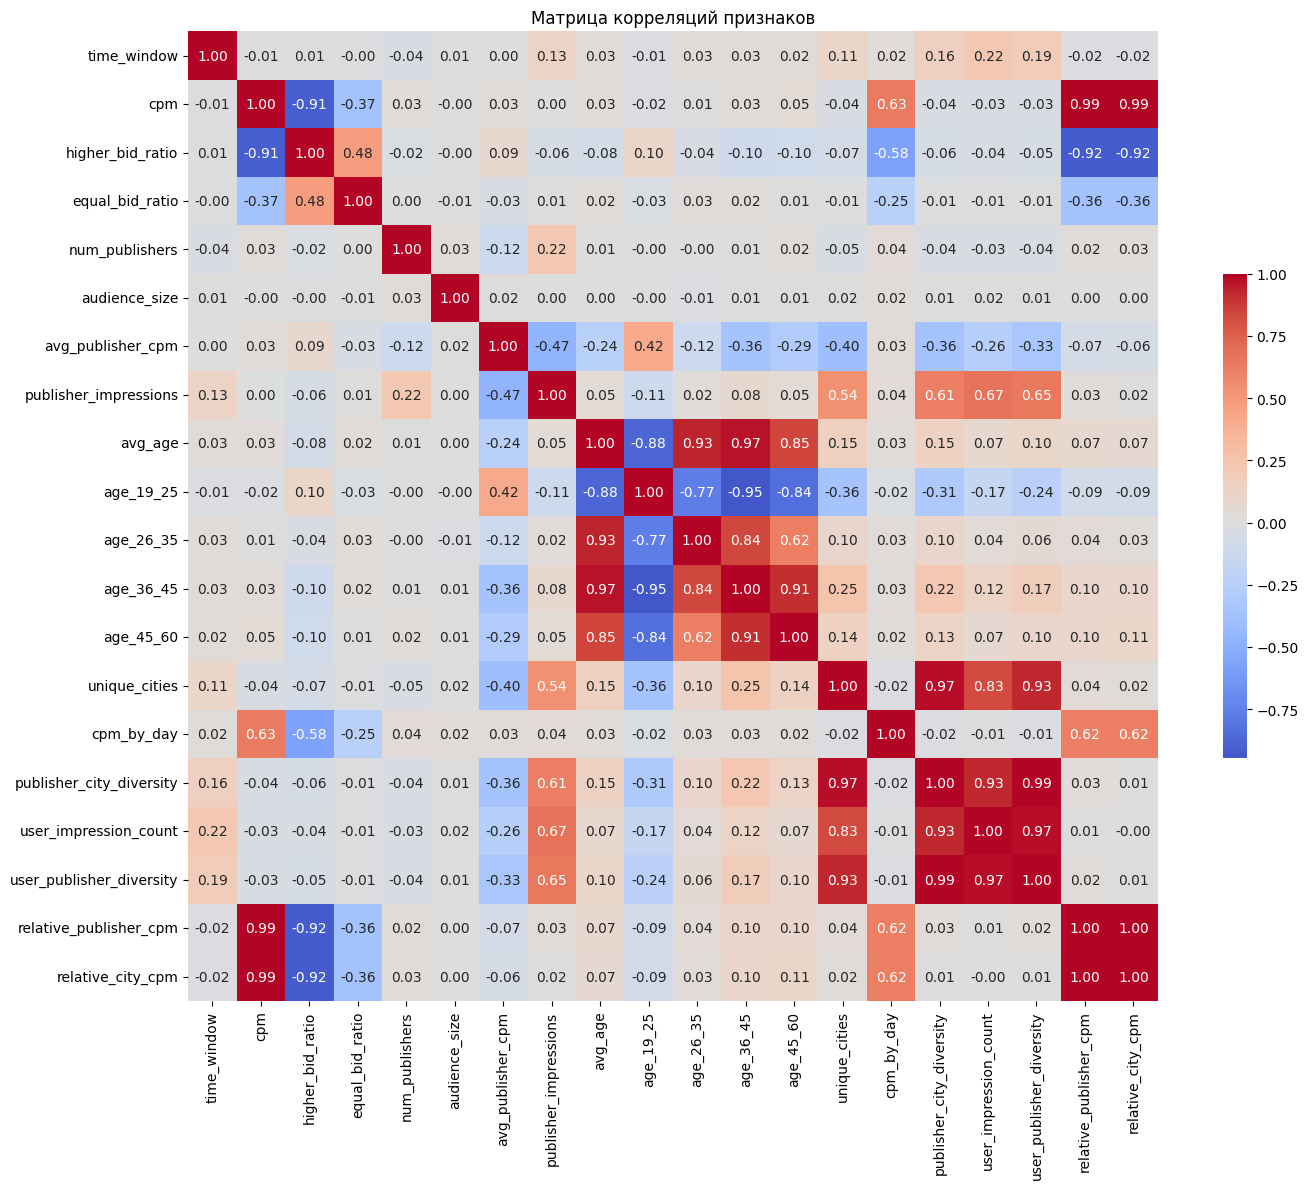

In [23]:
# Создаем матрицу корреляций
plt.figure(figsize=(15, 12))
correlation_matrix = X.corr()

# Создаем тепловую карту
sns.heatmap(
    correlation_matrix,
    annot=True,  # показываем значения
    cmap='coolwarm',  # цветовая схема
    center=0,  # центрируем цветовую шкалу на 0
    fmt='.2f',  # формат чисел (2 знака после запятой)
    square=True,  # делаем ячейки квадратными
    cbar_kws={"shrink": .5}  # размер цветовой шкалы
)

plt.title('Матрица корреляций признаков')
plt.tight_layout()
plt.show()

In [24]:
#Пробуем для каждого таргета отдельные фичи
feature_set = {}
feature_set['at_least_one']   = ['time_window','publisher_impressions','avg_publisher_cpm','relative_publisher_cpm','user_impression_count','user_publisher_diversity','audience_size','cpm','publisher_city_diversity','unique_cities','cpm_by_day','age_19_25']
feature_set['at_least_two']   = ['time_window','publisher_impressions','avg_publisher_cpm','relative_publisher_cpm','user_impression_count','audience_size','cpm','publisher_city_diversity','unique_cities','age_26_35','cpm_by_day','age_19_25']
feature_set['at_least_three'] = ['time_window','publisher_impressions','avg_publisher_cpm','relative_publisher_cpm','audience_size','cpm','publisher_city_diversity','unique_cities','cpm_by_day','age_19_25']


In [25]:


def objective(trial):
    params = {
        'iterations': 5000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 14),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0),
        'random_seed': 42,
        'verbose': 0,
        'task_type':'GPU',  
        'devices':'0' 
    }
    
    model = CatBoostRegressor(**params)
    model.fit(X_train[feature_set[target]], y_train[target], eval_set=(X_val[feature_set[target]], y_val[target]), early_stopping_rounds=100)
    
    y_pred = model.predict(X_val[feature_set[target]])
   
    smoothed_accuracy_ratio = getsingleerror(y_val[target], y_pred)
    return smoothed_accuracy_ratio

# Запускаем для каждого таргета

for target in ['at_least_one', 'at_least_two', 'at_least_three']:
    
    study = optuna.create_study(direction='minimize')  # Minimize the percentage error
    study.optimize(objective, n_trials=300)  # You can adjust the number of trials
 
    # Лучшая модель
    best_params = study.best_params
    best_model = CatBoostRegressor(**best_params)
    best_model.fit(X_train[feature_set[target]], y_train[target], eval_set=(X_val[feature_set[target]], y_val[target]), early_stopping_rounds=100)
    
    best_models[target] = best_model
    print(f"Best parameters for {target}: {best_params}")


[I 2024-12-19 13:11:45,115] A new study created in memory with name: no-name-636befb2-0c84-48a9-a4e4-967d368612f6
[I 2024-12-19 13:12:11,141] Trial 0 finished with value: 113.62042823069652 and parameters: {'learning_rate': 0.14452984687844064, 'depth': 12, 'l2_leaf_reg': 1.4439662050718196}. Best is trial 0 with value: 113.62042823069652.
[I 2024-12-19 13:12:19,394] Trial 1 finished with value: 89.88917464092638 and parameters: {'learning_rate': 0.0144491472396983, 'depth': 4, 'l2_leaf_reg': 8.657758576628071}. Best is trial 1 with value: 89.88917464092638.
[I 2024-12-19 13:12:23,036] Trial 2 finished with value: 94.8655073601549 and parameters: {'learning_rate': 0.1501687940343609, 'depth': 6, 'l2_leaf_reg': 9.721812484969345}. Best is trial 1 with value: 89.88917464092638.
[I 2024-12-19 13:12:35,777] Trial 3 finished with value: 97.26767583250202 and parameters: {'learning_rate': 0.1799558074638839, 'depth': 10, 'l2_leaf_reg': 8.651192743266172}. Best is trial 1 with value: 89.88917

0:	learn: 0.1466991	test: 0.1371736	best: 0.1371736 (0)	total: 4.06ms	remaining: 4.06s
1:	learn: 0.1444948	test: 0.1351121	best: 0.1351121 (1)	total: 7.18ms	remaining: 3.58s
2:	learn: 0.1425398	test: 0.1334162	best: 0.1334162 (2)	total: 10ms	remaining: 3.33s
3:	learn: 0.1408430	test: 0.1321494	best: 0.1321494 (3)	total: 12.9ms	remaining: 3.21s
4:	learn: 0.1389428	test: 0.1307327	best: 0.1307327 (4)	total: 15.9ms	remaining: 3.17s
5:	learn: 0.1370973	test: 0.1292639	best: 0.1292639 (5)	total: 18.7ms	remaining: 3.1s
6:	learn: 0.1353693	test: 0.1279900	best: 0.1279900 (6)	total: 21.6ms	remaining: 3.06s
7:	learn: 0.1335448	test: 0.1264215	best: 0.1264215 (7)	total: 24.4ms	remaining: 3.02s
8:	learn: 0.1319531	test: 0.1250240	best: 0.1250240 (8)	total: 27.3ms	remaining: 3s
9:	learn: 0.1305576	test: 0.1240538	best: 0.1240538 (9)	total: 28.8ms	remaining: 2.85s
10:	learn: 0.1292434	test: 0.1231957	best: 0.1231957 (10)	total: 30.2ms	remaining: 2.72s
11:	learn: 0.1278894	test: 0.1222700	best: 0.12

[I 2024-12-19 13:49:46,068] A new study created in memory with name: no-name-50a87eec-d4ae-478a-bcf0-1f1dc8f5e1f3


Best parameters for at_least_one: {'learning_rate': 0.03799760998460928, 'depth': 5, 'l2_leaf_reg': 7.703290496882217}


[I 2024-12-19 13:49:49,878] Trial 0 finished with value: 195.45129877909608 and parameters: {'learning_rate': 0.17214881884943667, 'depth': 7, 'l2_leaf_reg': 0.6647482235392834}. Best is trial 0 with value: 195.45129877909608.
[I 2024-12-19 13:50:12,444] Trial 1 finished with value: 114.54596345656837 and parameters: {'learning_rate': 0.11007899807591756, 'depth': 11, 'l2_leaf_reg': 6.5007640504266915}. Best is trial 1 with value: 114.54596345656837.
[I 2024-12-19 13:50:14,423] Trial 2 finished with value: 171.96789498139418 and parameters: {'learning_rate': 0.2607955319207793, 'depth': 4, 'l2_leaf_reg': 8.046955158886565}. Best is trial 1 with value: 114.54596345656837.
[I 2024-12-19 13:50:49,585] Trial 3 finished with value: 111.06858933651384 and parameters: {'learning_rate': 0.2557004658908206, 'depth': 12, 'l2_leaf_reg': 7.883909625998007}. Best is trial 3 with value: 111.06858933651384.
[I 2024-12-19 13:50:53,751] Trial 4 finished with value: 158.9464357375979 and parameters: {'l

0:	learn: 0.1176377	test: 0.1046926	best: 0.1046926 (0)	total: 2.56ms	remaining: 2.56s
1:	learn: 0.1139223	test: 0.1014273	best: 0.1014273 (1)	total: 5.11ms	remaining: 2.55s
2:	learn: 0.1105945	test: 0.0991207	best: 0.0991207 (2)	total: 7.62ms	remaining: 2.53s
3:	learn: 0.1077190	test: 0.0968069	best: 0.0968069 (3)	total: 10.2ms	remaining: 2.54s
4:	learn: 0.1050101	test: 0.0952670	best: 0.0952670 (4)	total: 12.7ms	remaining: 2.52s
5:	learn: 0.1023013	test: 0.0933395	best: 0.0933395 (5)	total: 15ms	remaining: 2.48s
6:	learn: 0.0999485	test: 0.0918754	best: 0.0918754 (6)	total: 17.4ms	remaining: 2.47s
7:	learn: 0.0975180	test: 0.0898685	best: 0.0898685 (7)	total: 19.9ms	remaining: 2.47s
8:	learn: 0.0956950	test: 0.0888229	best: 0.0888229 (8)	total: 22.4ms	remaining: 2.46s
9:	learn: 0.0938772	test: 0.0882119	best: 0.0882119 (9)	total: 25ms	remaining: 2.48s
10:	learn: 0.0918546	test: 0.0866938	best: 0.0866938 (10)	total: 28.1ms	remaining: 2.52s
11:	learn: 0.0903179	test: 0.0857591	best: 0.

[I 2024-12-19 14:27:50,964] A new study created in memory with name: no-name-c9becd6d-f4c5-4087-90e1-32461f5c4745


Best parameters for at_least_two: {'learning_rate': 0.0830063566061808, 'depth': 5, 'l2_leaf_reg': 5.81257481168307}


[I 2024-12-19 14:27:53,508] Trial 0 finished with value: 151.45151568400408 and parameters: {'learning_rate': 0.16244147424170988, 'depth': 7, 'l2_leaf_reg': 7.129479143643553}. Best is trial 0 with value: 151.45151568400408.
[I 2024-12-19 14:27:55,388] Trial 1 finished with value: 154.44607037653236 and parameters: {'learning_rate': 0.12921937392735763, 'depth': 5, 'l2_leaf_reg': 3.572299860765693}. Best is trial 0 with value: 151.45151568400408.
[I 2024-12-19 14:28:02,509] Trial 2 finished with value: 178.6695083020268 and parameters: {'learning_rate': 0.038552635650261846, 'depth': 10, 'l2_leaf_reg': 2.6222208506608427}. Best is trial 0 with value: 151.45151568400408.
[I 2024-12-19 14:28:11,589] Trial 3 finished with value: 150.42808982706975 and parameters: {'learning_rate': 0.2400121959426788, 'depth': 11, 'l2_leaf_reg': 6.271261569048283}. Best is trial 3 with value: 150.42808982706975.
[I 2024-12-19 14:28:15,241] Trial 4 finished with value: 147.31281563519946 and parameters: {'

0:	learn: 0.0964155	test: 0.0867389	best: 0.0867389 (0)	total: 58.9ms	remaining: 58.8s
1:	learn: 0.0885426	test: 0.0837061	best: 0.0837061 (1)	total: 99.1ms	remaining: 49.5s
2:	learn: 0.0819803	test: 0.0810718	best: 0.0810718 (2)	total: 138ms	remaining: 45.8s
3:	learn: 0.0768761	test: 0.0806354	best: 0.0806354 (3)	total: 178ms	remaining: 44.3s
4:	learn: 0.0713941	test: 0.0783444	best: 0.0783444 (4)	total: 229ms	remaining: 45.6s
5:	learn: 0.0660716	test: 0.0769542	best: 0.0769542 (5)	total: 283ms	remaining: 46.9s
6:	learn: 0.0616098	test: 0.0762090	best: 0.0762090 (6)	total: 337ms	remaining: 47.8s
7:	learn: 0.0576062	test: 0.0747663	best: 0.0747663 (7)	total: 391ms	remaining: 48.5s
8:	learn: 0.0535193	test: 0.0729946	best: 0.0729946 (8)	total: 443ms	remaining: 48.8s
9:	learn: 0.0496572	test: 0.0720285	best: 0.0720285 (9)	total: 494ms	remaining: 48.9s
10:	learn: 0.0467201	test: 0.0706960	best: 0.0706960 (10)	total: 543ms	remaining: 48.8s
11:	learn: 0.0441743	test: 0.0696538	best: 0.06965

In [26]:
# Получаем общую ошибку X_test датасета
responses = pd.DataFrame(index=range(len(X_test)), columns=['at_least_one', 'at_least_two', 'at_least_three'])

for target in ['at_least_one', 'at_least_two', 'at_least_three']:
    y_pred = best_models[target].predict(X_test[feature_set[target]])
    feature_importances = best_models[target].get_feature_importance()
    responses[target] = np.abs(y_pred)

    feature_names = X_test[feature_set[target]].columns  

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Set a threshold for feature importance
    threshold = 0.0  # You can adjust this value based on your analysis

    # Filter features based on the threshold
    important_features = importance_df[importance_df['Importance'] > threshold]
    important_features = important_features.nlargest(20, 'Importance')
    # Display the important features
    print("Important Features:")
    print(important_features)


test_accuracy_ratio = get_smoothed_mean_log_accuracy_ratio(responses, y_test)
print(f'Smoothed Mean Log Accuracy Ratio на тестовом датасете: {test_accuracy_ratio:.2f}%')


Important Features:
                     Feature  Importance
0                time_window   37.183313
1      publisher_impressions   22.052735
2          avg_publisher_cpm   11.206074
7                        cpm    5.255002
3     relative_publisher_cpm    5.147234
10                cpm_by_day    3.228865
9              unique_cities    3.161728
11                 age_19_25    2.808329
4      user_impression_count    2.805099
5   user_publisher_diversity    2.606546
8   publisher_city_diversity    2.390700
6              audience_size    2.154375
Important Features:
                     Feature  Importance
0                time_window   42.614014
1      publisher_impressions   19.081215
2          avg_publisher_cpm    8.928477
6                        cpm    5.751503
3     relative_publisher_cpm    4.176441
8              unique_cities    3.978474
10                cpm_by_day    3.151212
4      user_impression_count    2.946596
11                 age_19_25    2.602832
9                

In [27]:
# Получаем общую ошибку X_val датасета
responses = pd.DataFrame(index=range(len(X_val)), columns=['at_least_one', 'at_least_two', 'at_least_three'])

for target in ['at_least_one', 'at_least_two', 'at_least_three']:
    y_pred = best_models[target].predict(X_val[feature_set[target]])
    feature_importances = best_models[target].get_feature_importance()
    responses[target] = np.abs(y_pred)


test_accuracy_ratio = get_smoothed_mean_log_accuracy_ratio(responses, y_val)
print(f'Smoothed Mean Log Accuracy Ratio на val датасете: {test_accuracy_ratio:.2f}%')

Smoothed Mean Log Accuracy Ratio на val датасете: 356.29%


In [28]:
# Получаем общую ошибку X_train датасета
responses = pd.DataFrame(index=range(len(X_train)), columns=['at_least_one', 'at_least_two', 'at_least_three'])

for target in ['at_least_one', 'at_least_two', 'at_least_three']:
    y_pred = best_models[target].predict(X_train[feature_set[target]])
    feature_importances = best_models[target].get_feature_importance()
    responses[target] = np.abs(y_pred)


test_accuracy_ratio = get_smoothed_mean_log_accuracy_ratio(responses, y_train)
print(f'Smoothed Mean Log Accuracy Ratio на train датасете: {test_accuracy_ratio:.2f}%')

Smoothed Mean Log Accuracy Ratio на train датасете: 349.41%


In [29]:
# Получаем общую ошибку всего датасета
responses = pd.DataFrame(index=range(len(X)), columns=['at_least_one', 'at_least_two', 'at_least_three'])

for target in ['at_least_one', 'at_least_two', 'at_least_three']:
    y_pred = best_models[target].predict(X[feature_set[target]])
    feature_importances = best_models[target].get_feature_importance()
    responses[target] = np.abs(y_pred)


test_accuracy_ratio = get_smoothed_mean_log_accuracy_ratio(responses, y)
print(f'Smoothed Mean Log Accuracy Ratio на всем датасете: {test_accuracy_ratio:.2f}%')

Smoothed Mean Log Accuracy Ratio на всем датасете: 54.75%


In [30]:
responses.to_csv('responses.csv')